<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/DeviceFailureLikelihood.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Device Failure Model

The task is to model the likelihood of device failures over time. 

As per rigrous cross-validation, *a time-aware artificial neural network is superior to the baseline stateless model*.

It is also demonstrated how to use Tensorflow to conveniently *preprocess temporal data* as well as to *rigrously cross-validate temporal models*.

# Data Exploration

Note: a change in encoding is needed to read the data properly!

In [ ]:
import pandas as pd

df = pd.read_csv('device_failure.csv',encoding='ISO-8859-1')
df.head()

,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
0,2015-01-01,S1F01085,0,215630672,56,0,52,6,407438,0,0,7
1,2015-01-01,S1F0166B,0,61370680,0,3,0,6,403174,0,0,0
2,2015-01-01,S1F01E6Y,0,173295968,0,0,0,12,237394,0,0,0
3,2015-01-01,S1F01JE0,0,79694024,0,0,0,6,410186,0,0,0
4,2015-01-01,S1F01R2B,0,135970480,0,0,0,15,313173,0,0,3


What we handle is a family of multivariate time series: want to predict failures (0.1% of data) from device characteristics that evolve over time.

In [ ]:
print(f'Global failure rate (%) {df.failure.mean()*100}')
df[df.device=='S1F0E9EP']

Global failure rate (%) 0.0851446656063746


,date,device,failure,attribute1,attribute2,attribute3,attribute4,attribute5,attribute6,attribute7,attribute8,attribute9
75,2015-01-01,S1F0E9EP,0,106791400,0,0,0,8,196552,0,0,0
1238,2015-01-02,S1F0E9EP,0,126870472,0,0,0,8,197887,0,0,0
2401,2015-01-03,S1F0E9EP,0,147004000,0,0,0,8,199248,0,0,0
3564,2015-01-04,S1F0E9EP,0,169708424,0,0,0,8,200566,0,0,0
4725,2015-01-05,S1F0E9EP,0,191451728,0,0,0,8,201864,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...
124339,2015-10-27,S1F0E9EP,0,145381736,0,0,0,11,350560,0,0,0
124370,2015-10-29,S1F0E9EP,0,164996992,0,0,0,11,351502,0,0,0
124401,2015-10-30,S1F0E9EP,0,114624520,0,0,12,11,352053,0,0,0
124432,2015-10-31,S1F0E9EP,0,160500744,0,0,12,11,352064,0,0,0


*   Convert dates to the proper format.
*   Remove duplicates (device & date uniquely identify the rows)
*   Confirm no nulls in the data
*   Confirm that data is not time-contigous, 14% of time-series have holes, the model need to handle that



In [ ]:
df['date'] = pd.to_datetime(df['date'])

mask_dups = df.duplicated(subset=['device','date'])
print('Duplicated',mask_dups.sum())
df = df[~mask_dups]

mask_na = df.isna().any(1)
print('Nulls', mask_na.sum())
time_stats = df.groupby('device')['date'].agg(
    ['min','max','size']
)
mask_holes = (time_stats['max']-time_stats['min']).dt.days+1 != time_stats['size']
print('Time series with holes', mask_holes.mean())

Duplicated 1
Nulls 0
Time series with holes 0.14798973481608213


# Model



**Model**: Time-series models such as RNNs are the natural choice.  The model aims to predict the failure probability at each timestemp, using features available prior to (and including) the given timepoint. Models are implemented in [Tensorflow](https://www.tensorflow.org/). 

**Validation**: The area under the ROC curve (ROC_AUC) is used to asses the accuracy of the binary probabilistic classifier (appropriate as the data is imbalanced), and we expect to beat the level of 0.5 (random guess). The rigorous validation approach uses cross-validation on folds created so as not to break individual time-series (!). Evaluating on all temporal slices is conveniently solved with [TimeDistributed](https://www.tensorflow.org/api_docs/python/tf/keras/layers/TimeDistributed) layers.

**Data shape**: The input data is a float tensor of shape (devices,timesteps,features). The target is the binary tensor of device failure of shape (device,timesteps). 


**Preprocessing**: Masking/padding is needed as timeseries are of various length and have holes. This is handled conveniently with [Sparse Tensors](https://www.tensorflow.org/api_docs/python/tf/sparse/). In addition scaling is needed to ensure the proper model covergence.



## Preprocessing

This creates the input tensor of shape (devices,timesteps,features) = (1169,306,9) and applies standard scaling. 

The target is a binary tensor is of shape (devices,timesteps) = (1169,306).

In [ ]:
df['timestep']=df.groupby('device')['date'].transform(
    lambda s: (s-s.min()).dt.days
)
print('Max timesteps',df['timestep'].max()+1)

device_map = dict(zip(df.device.unique(),range(df.device.nunique()),))
df['device'] = df['device'].apply(device_map.get)
print('Max samples',df.device.nunique())

Max timesteps 306
Max samples 1169


In [ ]:
import numpy as np
import tensorflow as tf
from sklearn.preprocessing import StandardScaler

n_samples, n_timesteps, n_features = 1169, 306, 9

indices = zip(df['device'],df['timestep'])
indices = [tuple(t) for t in indices]
dense_shape = (n_samples,n_timesteps)


keep_cols = [f'attribute{i}' for i in range(1,n_features+1)]
X_t = StandardScaler().fit_transform(df[keep_cols])

ts = [tf.SparseTensor(indices,X_t[:,i],dense_shape) for i in range(n_features)]
X_t = tf.sparse.concat(sp_inputs=[tf.sparse.expand_dims(t,axis=-1) for t in ts],axis=-1)
X_t = tf.sparse.reorder(X_t)
X_t = tf.sparse.to_dense(X_t,default_value=-999).numpy()

y_t = tf.SparseTensor(indices,df['failure'].values.astype('float32'),dense_shape)
y_t = tf.sparse.reorder(y_t)
y_t = tf.sparse.to_dense(y_t).numpy()
y_t = np.expand_dims(y_t,-1)

index_t = tf.SparseTensor(indices,df['device'].values,dense_shape)
index_t = tf.sparse.reorder(index_t)
index_t = tf.sparse.to_dense(index_t).numpy()

## Baseline Model

The natural baseline is a linear model using only the current timestep data (no memory of past). 

The this simple model performs reasonably well (0.75 of ROC_AUC, cross-validated).

In [ ]:
from sklearn.model_selection import cross_val_score
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import GroupShuffleSplit, ShuffleSplit
from sklearn.linear_model import LogisticRegression

model = LogisticRegression(max_iter=1000)

cv = GroupShuffleSplit(n_splits=5, random_state=1234)
groups = index_t
mask = (X_t==-999).all(-1)
out = cross_val_score(model,X_t[~mask],y_t[~mask],cv=cv, groups=groups[~mask],scoring='roc_auc',n_jobs=-1)
print(f'ROC_AUC: {out.mean():.3f}+/-{out.std():.3f}')

ROC_AUC: 0.746+/-0.044


## Time-aware Model

By training an LSTM model we improve a bit to ROC_AUC=0.77, cross-validated.

Note that by default LSTMs embed the time dimension, to train and evaluate on all temporal slices we need to use the TimeDistributed layer.

In [ ]:
def build_tf_model():
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Masking(mask_value=-999,
                                    input_shape=(n_timesteps, n_features)))
  model.add(tf.keras.layers.LSTM(
      units=32,
      input_shape=(n_timesteps,n_features),return_sequences=True)
  )
  model.add(tf.keras.layers.TimeDistributed(
      tf.keras.layers.Dense(1,activation='sigmoid'))
  )
  model.compile(
      optimizer=tf.keras.optimizers.Adam(1e-2), 
      loss='binary_crossentropy',
      #metrics=tf.keras.metrics.AUC(curve='ROC'),
  )    
  return model

In [ ]:
tf.random.set_seed(1234)

out = []
for train_idxs,test_idxs in ShuffleSplit(n_splits=5,test_size=0.2,random_state=1234).split(np.arange(n_samples)):
  model = build_tf_model()
  X_train,y_train = X_t[train_idxs],y_t[train_idxs]
  X_test,y_test = X_t[test_idxs],y_t[test_idxs]
  model.fit(X_train,y_train,epochs=20,batch_size=32)
  score = roc_auc_score(y_test.ravel(),model(X_test).numpy().ravel())
  print(score)
  out.append(score)


out = np.array(out)
print(f'ROC_AUC: {out.mean():.3f}+/-{out.std():.3f}')

Epoch 1/20
30/30 [==============================] - 18s 280ms/step - loss: 0.0376
Epoch 2/20
30/30 [==============================] - 5s 165ms/step - loss: 0.0045
Epoch 3/20
30/30 [==============================] - 5s 165ms/step - loss: 0.0039
Epoch 4/20
30/30 [==============================] - 5s 164ms/step - loss: 0.0036
Epoch 5/20
30/30 [==============================] - 5s 166ms/step - loss: 0.0033
Epoch 6/20
30/30 [==============================] - 5s 166ms/step - loss: 0.0031
Epoch 7/20
30/30 [==============================] - 7s 229ms/step - loss: 0.0029
Epoch 8/20
30/30 [==============================] - 9s 302ms/step - loss: 0.0027
Epoch 9/20
30/30 [==============================] - 6s 181ms/step - loss: 0.0026
Epoch 10/20
30/30 [==============================] - 5s 163ms/step - loss: 0.0025
Epoch 11/20
30/30 [==============================] - 5s 165ms/step - loss: 0.0025
Epoch 12/20
30/30 [==============================] - 5s 160ms/step - loss: 0.0024
Epoch 13/20
30/30 [=====

# Architecture

The right architecture depends on the use case. I believe device failure should be available on demand (via REST API or so), but its retraining can be done at a regularly schedule as suggested by the data aggregation (every day or every few hours). 

The picture could be like (source: https://neptune.ai/blog/mlops-architecture-guide)

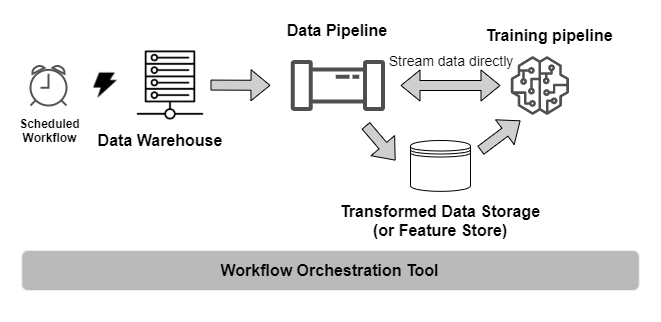